<a href="https://colab.research.google.com/github/GusMalija/Master-Thesis-Project-Augustine-Malija/blob/main/baseline_experimentation_hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#calling important libraries
import pandas as pd #for data manipulation
import numpy as np #for data manipulation
import matplotlib as plt #for plotting
import os #for ease of python system interaction
import sys
import re
import nltk
nltk.download("stopwords")
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#retrieving the data
url = "https://raw.githubusercontent.com/ApollineFo/NPL/main/data/labeled_data.csv"

data = pd.read_csv(url)
#checking the dataset features
data.keys()

#removing offensive tweets
data = data[data["class"] !=1]
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
40,40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """
63,63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,67,3,0,1,2,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."


In [ ]:
#extracting only tweets as features
features = data.iloc[:,6].values
#extracting labels
classes = data.iloc[:,5].values

Removal of unwanted text from data leads to clean textual data that can easily be transformed to numeric arrays ready to be subjected to machine learning techniques. Thus, we end up with results from which we can deduce the extent to which hate speech was detected. Corollary text preprocessing offers the opportunity for the model’s optimality to be tested.


In [ ]:
#preprocessing tweets
processed_features = []

for sentence in range(0, len(features)):
    #Removing special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    #removing single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    #Removing single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    #Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    #Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    #Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

Both Gaussian and Linear kernels were specified to take care of irregularities that may have arisen from the dataset the machine learning model runs. With a Gaussian kernel, I specified a kernel coefficient "gamma" of zero. I set the class weight to "balanced" to automatically adjust weights/probabilities inversely proportional to class frequencies. I did not have to specify further for a linear kernel since it regards the dataset as a regular one with no imbalances.

Since I have more than one class of tweets categorization - hate speech and neutral, I built a pipeline that applies a TF-IDF vectorizer taking into account the parameters I specified. It also uses an OneVsRest classier of SVC that takes into account probabilities/weights. With these in check, I separated my dataset to train and test sets where I have 80 percent of the data as a training set while 20 percent of it as a test set. I then use a Grid Search to do an exhaustive search over parameter values where all processors are used. To be concise, I control the verbosity of messages by only allowing computation time and parameter candidates for each fold to be displayed. The use of Grid search is deemed paramount since it picks the best performing kernel out of the Gaussian and linear ones I specified earlier. The output it produces is one for the best-performing kernel. In this regard, I did not have to worry about being explicit of a single kernel among the two. I then built a classifier by fitting my training sets from which I was able to predict my test set.


In [ ]:
#specifying parameters
parameters = [
    {
    'vect__max_df': (0.9,), #ignore terms with frequency higher than aforementioned
        'vect__min_df': (2,), #ignore lower frequencies than aforementioned
        'vect__ngram_range': ((1, 2),), #only unigrams
        'clf__estimator__kernel': ['rbf'], #gausian kernel
    'clf__estimator__gamma': [1e0,], #a gamma of zero
        'clf__estimator__C': [1,],
        'clf__estimator__class_weight': [None, "balanced"] #balanced weight
    },
    {
        'vect__max_df': (0.9,),
        'vect__min_df': (2,),
        'vect__ngram_range': ((1, 2),),
        'clf__estimator__kernel': ['linear'], #linear kernel
    'clf__estimator__C': [1,]
    }
]

In [ ]:
# building a pipeline
pipeline = Pipeline([('vect', TfidfVectorizer(parameters)),                     
    ('clf', OneVsRestClassifier(SVC(probability=True))),
])

In [ ]:
#splitting the dataset to trian and test set
#80 percent of data for training, 20 percent for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, classes, test_size=0.2, random_state=42)

In [ ]:
#grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [ ]:
#fitting the classifier
classifier = grid_search.fit(X_train, y_train)

#predicting
y_predict = classifier.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


In [ ]:
#confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

[[222  65]
 [ 16 816]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.85       287
           2       0.93      0.98      0.95       832

    accuracy                           0.93      1119
   macro avg       0.93      0.88      0.90      1119
weighted avg       0.93      0.93      0.93      1119



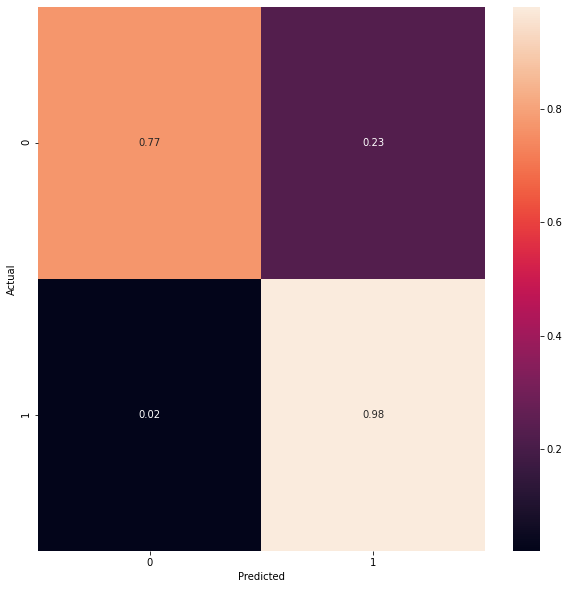

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_predict)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.savefig('cmn.png')

From the normalized confusion matrix below, zeros represent tweets classified as hate speech while ones represent tweets classified as neutral. This is owning data annotation that was cross-checked through the inter-annotator agreement. We can see that the  model correctly predicted about 77 percent of tweets that related to hate speech. On the other hand, 98 percent of tweets that did not relate to hate speech (classified as neutral) were predicted correctly. No model is perfect, and this applies to this model too. In this light, about 2 percent of tweets that were related to hate speech were classified as neutral, while about 23 percent of neutral tweets were classified as hate speech. Several reasons could explain such a minor flaw, but an important one is tweets that are hard for a human annotators to annotate. Nevertheless, the baseline model performs pretty well since it achieves an accuracy score of 93 percent.

In [ ]:
#evaluating the model with ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict, multi_class="ovr")

#with a higher score than 0.5, signifies that our model is useful.

0.8771441972661485

With ROC AUC score, I am computing the area under the receiver operating characteristics from the prediction scores. This served as the first evaluation technique because it is easy to interpret, with a single score being above 0.5 means that the model is performing suitably well. As it turned out, the model performed well with this technique since the ROC AUC score was 0.882, meaning that the model is doing a very good job.

In [ ]:
#evaluating the model using cross validation
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

#returning accuracies of the folds
print(all_accuracies)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


[0.92625698 0.92849162 0.9273743  0.93072626 0.9261745 ]


Cross-validation was used to determine the level of model precision. By running cross-validation, standard deviation score can be obtained—the lower the standard deviation, the more precise the model. The model turned out to be good since the standard deviation score obtained was 0.004, which is relatively low, suggesting that the model’s precision is too high for standards. With such a precise standard deviation, the model can apply to an even larger dataset.


In [ ]:
#printing standard deviation of accuracies
print(all_accuracies.std())

#earning a low variance meaning; a good indicator that the model will perform similar on all test sets and the prediction obtained is not by chance

0.0016879328960567243
